In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [3]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [4]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('I:\study\dpl\project\Dataset\Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )

validation_generator =  test_datagen.flow_from_directory( 'I:\study\dpl\project\Dataset\Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.VGG19(input_shape=input_shape,include_top=False,weights="imagenet")

In [6]:
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         589952    
                                                        

In [7]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [8]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model_vgg19.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [9]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\asus\AppData\Local\Temp\ipykernel_20560\2476792664.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


Epoch 1/8
256/256 [==============================] - 380s 1s/step - loss: 0.6813 - accuracy: 0.6543 - val_loss: 0.5846 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 2/8
256/256 [==============================] - 409s 2s/step - loss: 0.4290 - accuracy: 0.8029 - val_loss: 0.2834 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 3/8
256/256 [==============================] - 375s 1s/step - loss: 0.3040 - accuracy: 0.8753 - val_loss: 0.7103 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 4/8
256/256 [==============================] - 396s 2s/step - loss: 0.2617 - accuracy: 0.8959 - val_loss: 0.3210 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 5/8
256/256 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9099
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
256/256 [==============================] - 375s 1s/step - loss: 0.2254 - accuracy: 0.9099 - val_loss: 0.3117 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 5: early stopping


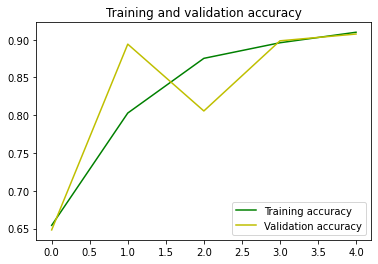

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
test_generator =  test_datagen.flow_from_directory( 'I:\study\dpl\project\Dataset\Test',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)
score = model.evaluate_generator(generator=validation_generator,steps=256)

Found 20001 images belonging to 2 classes.


C:\Users\asus\AppData\Local\Temp\ipykernel_20560\612800173.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(generator=validation_generator,steps=256)


In [12]:
print(score)

[0.30913910269737244, 0.90753173828125]


In [13]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib

from keras.preprocessing import image
#  images test 1
path_testmodel = "I:/study/dpl/project/Dataset/testmodel/test1.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)

X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)


images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "I:/study/dpl/project/Dataset/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")

plt.imshow(imge)